# Ultilities

In [1]:
# Essentials
import pickle
import os
import math
import numpy as np
import pandas as pd
import random
import time

# Visualization
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm.notebook import tqdm

# PyTorch
import torch
from torch.multiprocessing import cpu_count
from torch.optim import RMSprop
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler, SequentialSampler
from torch import nn  
from torch.nn import functional as F
import torchvision
from torchvision import datasets, transforms, models
from torchvision.transforms import functional as tvf

# Model
from efficientnet_pytorch import EfficientNet

from sklearn.manifold import TSNE

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [3]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

## Data generator

In [4]:
s = 0.5
data_transforms = transforms.Compose([transforms.RandomHorizontalFlip(0.5),
                                      transforms.RandomResizedCrop(32,(0.8,1.0)),
                                      transforms.Compose([transforms.RandomApply([transforms.ColorJitter(0.8*s, 0.8*s, 0.8*s, 0.2*s)], p = 0.8),
                                                          transforms.RandomGrayscale(p=0.2)])
                                      ])

In [5]:
def random_rotate(image):
    if random.random() > 0.5:
        return tvf.rotate(image, angle=random.choice((0, 90, 180, 270)))
    return image

class ResizedRotation():
    def __init__(self, angle, output_size=(96, 96)):
        self.angle = angle
        self.output_size = output_size
        
    def angle_to_rad(self, ang): return np.pi * ang / 180.0
        
    def __call__(self, image):
        w, h = image.size
        new_h = int(np.abs(w * np.sin(self.angle_to_rad(90 - self.angle))) + np.abs(h * np.sin(self.angle_to_rad(self.angle))))
        new_w = int(np.abs(h * np.sin(self.angle_to_rad(90 - self.angle))) + np.abs(w * np.sin(self.angle_to_rad(self.angle))))
        img = tvf.resize(image, (new_w, new_h))
        img = tvf.rotate(img, self.angle)
        img = tvf.center_crop(img, self.output_size)
        return img

class WrapWithRandomParams():
    def __init__(self, constructor, ranges):
        self.constructor = constructor
        self.ranges = ranges
    
    def __call__(self, image):
        randoms = [float(np.random.uniform(low, high)) for _, (low, high) in zip(range(len(self.ranges)), self.ranges)]
        return self.constructor(*randoms)(image)

PretrainingDatasetWrapper

In [6]:
class PretrainingDatasetWrapper(Dataset):
    def __init__(self, ds: Dataset, target_size=(96, 96), real_labels=False):
        super().__init__()
        self.ds = ds
        self.target_size = target_size
        self.real_labels = real_labels
        self.preprocess = transforms.Compose([transforms.ToTensor(),
                                              transforms.Normalize(mean=[0.5, 0.5, 0.5],
                                                                   std=[0.5, 0.5, 0.5])])
        self.random_resized_rotation = WrapWithRandomParams(lambda angle: ResizedRotation(angle, target_size), [(0.0, 360.0)])
        self.randomize = transforms.Compose([transforms.RandomResizedCrop(target_size, scale=(1/3, 1.0), ratio=(0.3, 2.0)), 
                                             transforms.RandomChoice([transforms.RandomHorizontalFlip(p=0.5),
                                                                      transforms.Lambda(random_rotate)]), 
                                             transforms.RandomApply([self.random_resized_rotation], p=0.33),
                                             transforms.RandomApply([transforms.ColorJitter(brightness=0.5, 
                                                                                            contrast=0.5, 
                                                                                            saturation=0.5, 
                                                                                            hue=0.2)], 
                                                                    p=0.8),
                                             transforms.RandomGrayscale(p=0.2)])
    
    def __len__(self):
        return len(self.ds)
    
    def __getitem_internal__(self, idx, preprocess=True):
        this_image_raw, labels = self.ds[idx]
        t1 = self.randomize(this_image_raw)
        t2 = self.randomize(this_image_raw)
        t1 = self.preprocess(t1) if preprocess else transforms.ToTensor()(t1)
        t2 = self.preprocess(t2) if preprocess else transforms.ToTensor()(t2)
        labels = labels if self.real_labels else torch.tensor(0)
        return (t1, t2), labels

    def __getitem__(self, idx):
        return self.__getitem_internal__(idx, True)
    
    def raw(self, idx):
        return self.__getitem_internal__(idx, False)

## Contractive Loss

In [7]:
class ContrastiveLoss(nn.Module):
    def __init__(self, batch_size, temperature=0.5):
        super().__init__()
        self.batch_size = batch_size
        self.register_buffer("temperature", torch.tensor(temperature))
        self.register_buffer("negatives_mask", (~torch.eye(batch_size * 2, batch_size * 2, dtype=bool)).float())
            
    def forward(self, emb_i, emb_j):
        """
        emb_i and emb_j are batches of embeddings, where corresponding indices are pairs
        z_i, z_j as per SimCLR paper
        """
        z_i = F.normalize(emb_i, dim=1)
        z_j = F.normalize(emb_j, dim=1)

        representations = torch.cat([z_i, z_j], dim=0)
        similarity_matrix = F.cosine_similarity(representations.unsqueeze(1), representations.unsqueeze(0), dim=2)
        
        sim_ij = torch.diag(similarity_matrix, self.batch_size)
        sim_ji = torch.diag(similarity_matrix, -self.batch_size)
        positives = torch.cat([sim_ij, sim_ji], dim=0)
        
        nominator = torch.exp(positives / self.temperature)
        denominator = self.negatives_mask.to(similarity_matrix.device) * torch.exp(similarity_matrix / self.temperature)
        loss_partial = -torch.log(nominator / torch.sum(denominator, dim=1))
        loss = torch.sum(loss_partial) / (2 * self.batch_size)
        return loss

## ImageEmbedding

In [8]:
class ImageEmbedding(nn.Module):       
    class Identity(nn.Module):
        def __init__(self): super().__init__()

        def forward(self, x):
            return x
    
        
    def __init__(self, embedding_size=1024):
        super().__init__()
        
        base_model = EfficientNet.from_pretrained("efficientnet-b0")
        internal_embedding_size = base_model._fc.in_features
        base_model._fc = ImageEmbedding.Identity()
        
        self.embedding = base_model
        
        self.projection = nn.Sequential(
            nn.Linear(in_features=internal_embedding_size, out_features=embedding_size),
            nn.ReLU(),
            nn.Linear(in_features=embedding_size, out_features=embedding_size)
        )

    def calculate_embedding(self, image):
        return self.embedding(image)

    def forward(self, X):
        image = X
        embedding = self.calculate_embedding(image)
        projection = self.projection(embedding)
        return embedding, projection


## Plot feature

In [9]:
def plot_features(model, num_class, num_feats, batch_size, vdl):
    feats = np.empty([0, num_feats])
    labels = np.empty(0, dtype=int)
    model.eval()
    with torch.no_grad():
        for (x1, x2), y  in vdl:
            x1 = x1.squeeze().to(device, dtype = torch.float)
            x1_emb, x1_proj = model(x1)
            x1_proj = x1_proj.cpu().numpy()
            feats = np.append(feats, x1_proj, axis=0)
            labels = np.append(labels, y, axis=0)
    
    tsne = TSNE(n_components = 2, perplexity = 50)
    x_feats = tsne.fit_transform(feats)
    num_samples = int(batch_size*(val_size//batch_size))
    
    plt.figure(figsize=(20, 20))
    for i in range(num_class):
        plt.scatter(x_feats[labels[:num_samples]==i,1],x_feats[labels[:num_samples]==i,0],alpha=0.2)
    plt.legend([str(i) for i in range(num_class)], loc=4, ncol=(num_class + 1) // 2)
    plt.show()

# 2. Dataset and dataloader

In [10]:
# Directories
data_dir = "/storage/intern"
label_path = "./mat/MatLB3"
params_path = "./model/model_params"
experiment = "mat"
# Define parameter
batch_size = 128
num_workers = 2

In [11]:
# Dataset
train_set = datasets.ImageFolder(os.path.join(data_dir, "train"))
val_set = datasets.ImageFolder(os.path.join(data_dir, "val"))
# Loader
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=num_workers)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, shuffle=False, num_workers=num_workers)

Dataset characteristic

In [12]:
train_size = len(train_set)
val_size = len(val_set)
num_batches = math.floor(train_size/batch_size)
print(f"Train dataset: {train_size}")
print(f"Val dataset: {val_size}")
print(f"Number of batches: {num_batches}")

Train dataset: 52766
Val dataset: 13247
Number of batches: 412


In [13]:
label_names = train_set.classes
num_class = len(label_names)
print(f"Number of classes: {num_class}")
print(label_names)

Number of classes: 30
['calf', 'canvas', 'coatedcanvas', 'crocodile', 'denim', 'enamel', 'flora canvas', 'gg crystal', 'gg embossed leather', 'gg imprime ', 'gg nylon', 'gg plus', 'gg supreme canvas', 'ggcanvas', 'guccissima', 'guccissima nylon', 'jacquard ', 'leather', 'leather+canvas', 'linen', 'lizard', 'microguccissima', 'nubuck', 'nylon', 'ostrich', 'python', 'quilted leather', 'suede', 'suede+leather', 'velvet']


# Data after generation

In [14]:
ds = PretrainingDatasetWrapper(train_set)

In [15]:
idx = 123

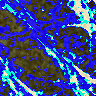

In [16]:
tvf.to_pil_image(ds[idx][0][0])

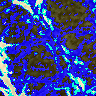

In [17]:
tvf.to_pil_image(ds[idx][0][1])

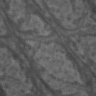

In [18]:
tvf.to_pil_image(ds.raw(idx)[0][1])

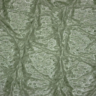

In [19]:
tvf.to_pil_image(ds.raw(idx)[0][0])

# Model

Load model

In [20]:
model = ImageEmbedding()
model = model.to(device)

Loaded pretrained weights for efficientnet-b0


Plot feature

/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


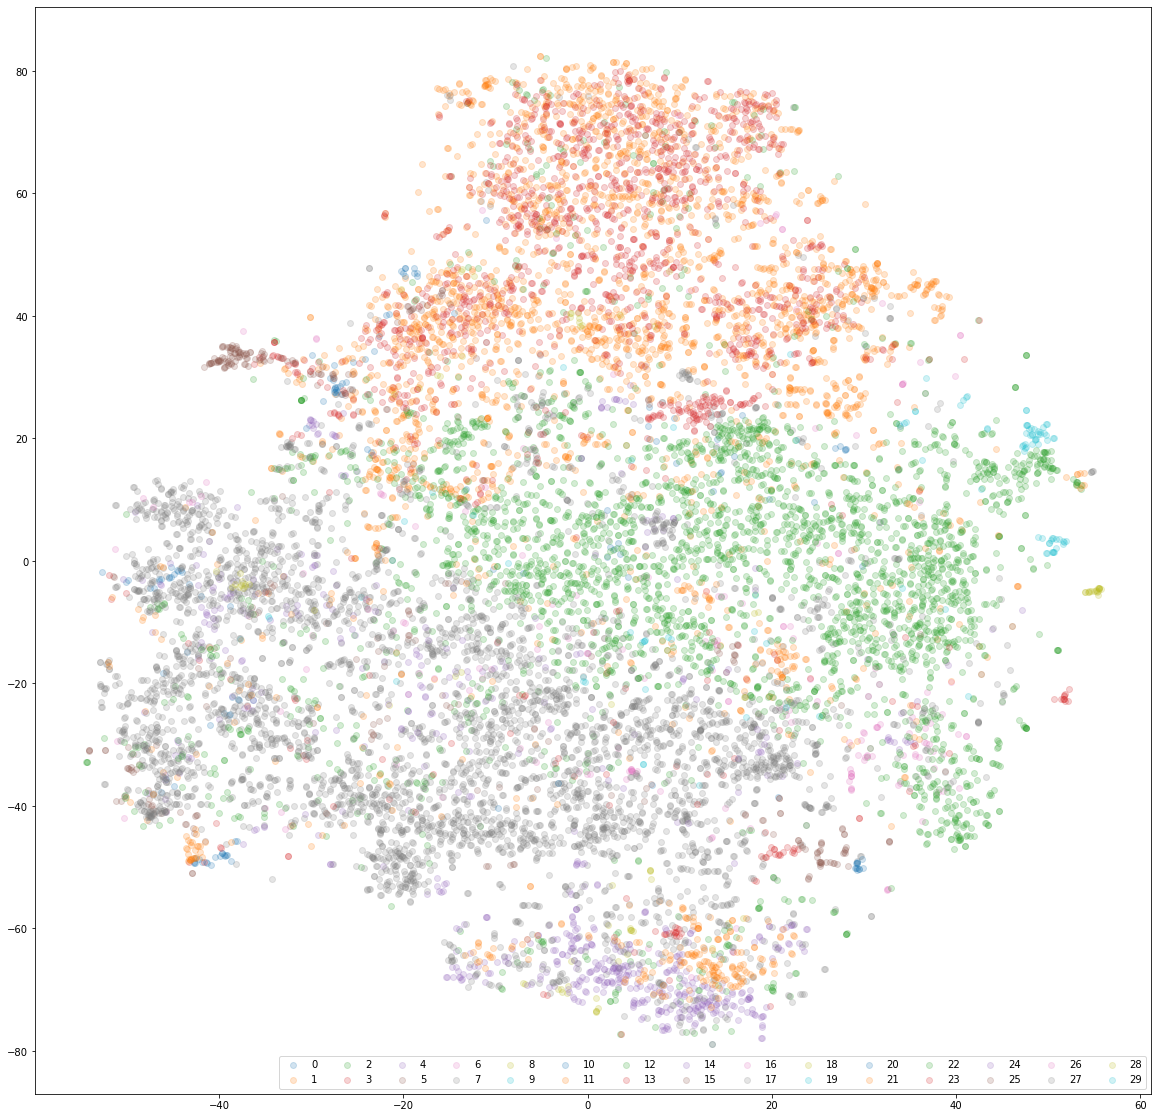

In [21]:
vld_labels = DataLoader(PretrainingDatasetWrapper(val_set, real_labels=True),
                        batch_size=128, 
                        shuffle=False, 
                        num_workers=cpu_count(),
                        drop_last=True)
plot_features(model, num_class, 1024, 128, vld_labels)

# Train

Loader

In [22]:
train_loader = DataLoader(PretrainingDatasetWrapper(train_set),
                        batch_size=128, 
                        shuffle=False, 
                        num_workers=cpu_count(),
                        drop_last=True)
#return (t1, t2), labels

optimizer

In [23]:
# optimizer = LARS(
#     [params for params in model.parameters() if params.requires_grad],
#     lr=0.2,
#     weight_decay=1e-6,
#     exclude_from_weight_decay=["batch_normalization", "bias"],
# )

# "decay the learning rate with the cosine decay schedule without restarts"
# warmupscheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lambda epoch : (epoch+1)/10.0, verbose = True)
# mainscheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, 500, eta_min=0.05, last_epoch=-1, verbose = True)

In [24]:
lr = 0.000758
optimizer = RMSprop(model.parameters(), lr=lr)

criterion

In [25]:
criterion = ContrastiveLoss(batch_size = 128, temperature = 0.5)

Train

In [26]:
def train(train_loader, model, criterion, optimizer):
    loss_epoch = 0
    
    for step, batch in enumerate(train_loader):
        (t1, t2), _ = batch
        optimizer.zero_grad()
        t1 = t1.squeeze().to(device).float()
        t2 = t2.squeeze().to(device).float()

        # positive pair, with encoding
        t1_emb, t1_proj = model(t1)
        t2_emb, t2_proj = model(t2)

        loss = criterion(t1_proj, t2_proj)
        loss.backward()

        optimizer.step()
        
        if step % 100 == 0:
            print(f"Step [{step}/{len(train_loader)}]\t Loss: {round(loss.item(), 5)}")

        loss_epoch += loss.item()
    return loss_epoch

In [27]:
def valid(valid_loader, model, criterion):
    loss_epoch = 0
    for step, batch in enumerate(valid_loader):
        (t1, t2), _ = batch
        t1 = t1.squeeze().to(device).float()
        t2 = t2.squeeze().to(device).float()

        # forward
        t1_emb, t1_proj = model(t1)
        t2_emb, t2_proj = model(t2)
        loss = criterion(t1_proj, t2_proj)
        
        if step % 100 == 0:
            print(f"Step [{step}/{len(valid_loader)}]\t Loss: {round(loss.item(),5)}")

        loss_epoch += loss.item()
    return loss_epoch

In [28]:
global_step = 0
current_epoch = 0
epochs = 100
tr_loss = []
val_loss = []

Epoch [0/100]	
Step [0/412]	 Loss: 5.40984
Step [100/412]	 Loss: 4.55543
Step [200/412]	 Loss: 4.61996
Step [300/412]	 Loss: 4.41751
Step [400/412]	 Loss: 4.53182
Step [0/103]	 Loss: 4.55038
Step [100/103]	 Loss: 4.39039
Epoch [0/100]	 Training Loss: 4.542309220554759	 lr: 0.00076
Epoch [0/100]	 Validation Loss: 4.707650842018498	 lr: 0.00076
Epoch [0/100]	 Time Taken: 4.128459294637044 minutes
Epoch [1/100]	
Step [0/412]	 Loss: 4.35559
Step [100/412]	 Loss: 4.3384
Step [200/412]	 Loss: 4.51815
Step [300/412]	 Loss: 4.33227
Step [400/412]	 Loss: 4.43944
Step [0/103]	 Loss: 4.58866
Step [100/103]	 Loss: 4.31241
Epoch [1/100]	 Training Loss: 4.345400930608361	 lr: 0.00076
Epoch [1/100]	 Validation Loss: 4.679434878154866	 lr: 0.00076
Epoch [1/100]	 Time Taken: 4.128789142767588 minutes
Epoch [2/100]	
Step [0/412]	 Loss: 4.25983
Step [100/412]	 Loss: 4.32657
Step [200/412]	 Loss: 4.43613
Step [300/412]	 Loss: 4.31854
Step [400/412]	 Loss: 4.41963
Step [0/103]	 Loss: 4.62003
Step [100/103]

/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


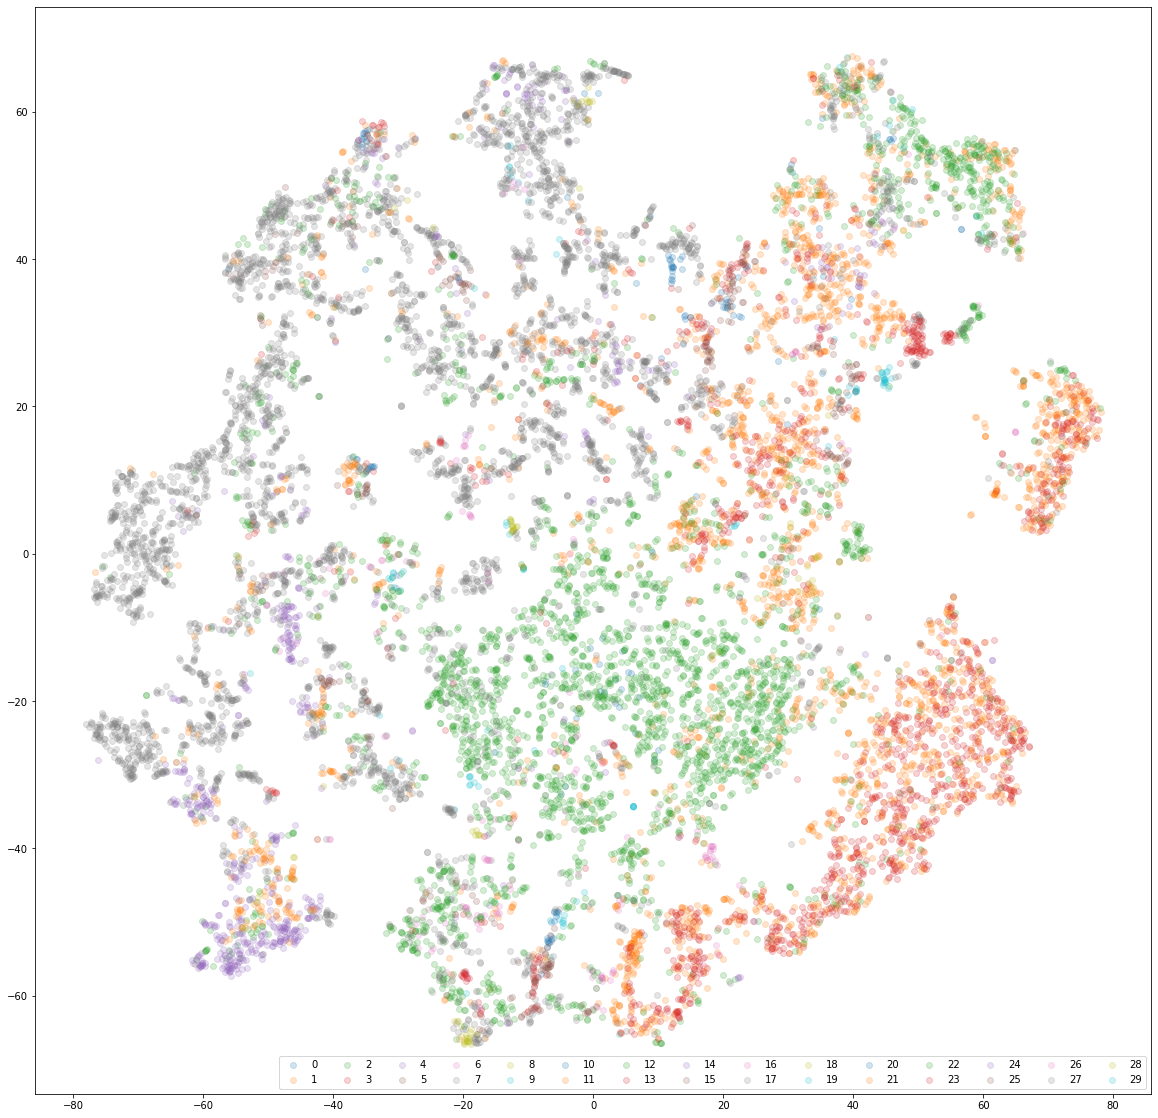

Epoch [10/100]	
Step [0/412]	 Loss: 4.13981
Step [100/412]	 Loss: 4.16894
Step [200/412]	 Loss: 4.17733
Step [300/412]	 Loss: 4.17457
Step [400/412]	 Loss: 4.25553
Step [0/103]	 Loss: 4.56355


KeyboardInterrupt: 

In [29]:
epochs = 100
for epoch in range(100):
        
    print(f"Epoch [{epoch}/{epochs}]\t")
    start_time = time.time()

    model.train()
    train_loss_epoch = train(train_loader, model, criterion, optimizer)

    if (epoch+1) % 100 == 0:
        print("save_model")

    model.eval()
    with torch.no_grad():
        val_loss_epoch = valid(vld_labels, model, criterion)

    tr_loss.append(train_loss_epoch / len(train_loader))
    val_loss.append(val_loss_epoch / len(vld_labels))
    print(f"Epoch [{epoch}/{epochs}]\t Training Loss: {train_loss_epoch / len(train_loader)}\t lr: {round(lr, 5)}")
    print(f"Epoch [{epoch}/{epochs}]\t Validation Loss: {val_loss_epoch / len(vld_labels)}\t lr: {round(lr, 5)}")
    current_epoch += 1

    # dg.on_epoch_end()

    time_taken = (time.time() - start_time)/60
    print(f"Epoch [{epoch}/{epochs}]\t Time Taken: {time_taken} minutes")

    if (epoch+1)%10==0:
        plot_features(model, num_class, 1024, 128, vld_labels)

## end training
# save_model(model, optimizer, mainscheduler, current_epoch, "SimCLR_CIFAR10_RN50_P128_LR0P2_LWup10_Cos500_T0p5_B128_checkpoint_{}_260621.pt")

In [ ]:
# Save model parameters
params_path = "exp/params"
torch.save(model.state_dict(), params_path)

: 